## **Modeling & Model Selection**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import joblib

# libraries for plot visuals
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load preprocessed dataset
df = pd.read_csv('Preprocessed_Malaria_Data.csv')

In [4]:
# Select features and target
X = df.drop(columns=['Malaria_incidence','Malaria_incidence_log', 'Country', 'Date'])
y = df['Malaria_incidence_log']

In [5]:
# Train and test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#### **Model 1: ElasticNet Model**

In [6]:
# Linear Regression Model (ElasticNet)
Enet_model = ElasticNet(random_state=42)

# Train 
elastic_net = Enet_model.fit(X_train, y_train)
y_pred = Enet_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
    
print(f"RSME: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RSME: 0.7024
R2 Score: 0.5365


---

- The yielded Root Mean Squared Error (RMSE) of the ElasticNet model, means that on average, its predictions deviate from the actual log malaria incidence by approximately 0.70 units. 
- The R² indicates that the model explains about 53.65% of the variance in the target variable.

This is a modest result because ElasticNet is a linear model and may not fully capture the non-linear relationships in the data.

---

#### **Finding the Important Features Based on the ElasticNet Model**

Selected Features:
 Population                 -2.591717e-10
Malaria_cases               2.603889e-06
Malaria_deaths             -9.743467e-07
Total_rainfall             -6.669075e-05
Altitude                    6.694977e-06
Temp_Humidity_Index         2.696330e-05
Rainfall_diff              -2.251667e-05
Total_rainfall_lag2        -9.563225e-05
Temp_Humidity_Index_lag1    1.313455e-05
Temp_Humidity_Index_lag2    1.878310e-05
dtype: float64


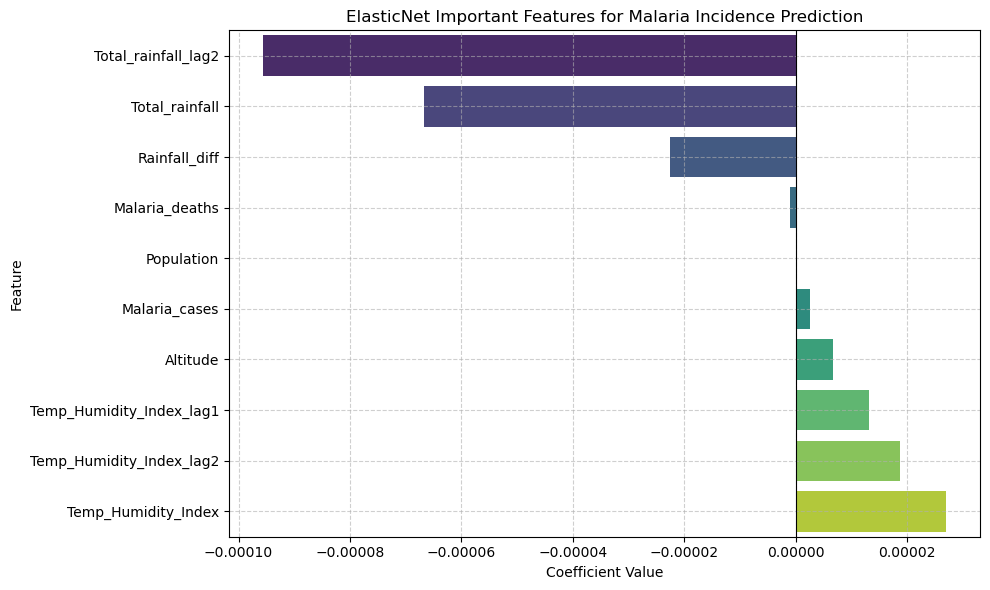

In [7]:
# Get ElasticNet coefficients
elasticnet_coefficients = pd.Series(elastic_net.coef_, index=X_train.columns)

# Select features with non-zero coefficients
selected_features = elasticnet_coefficients[elasticnet_coefficients != 0]
print("Selected Features:\n", selected_features)

# Sort the features by importance
important_features = selected_features.sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=important_features.values, y=important_features.index, palette="viridis")
plt.title('ElasticNet Important Features for Malaria Incidence Prediction')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---

The bar chart of non-zero coefficients reveals which features the ElasticNet model considers most important (positively & negatively) for malaria incidence (log-transformed).
This helps in identifying drivers or protectors of malaria incidence under linear assumptions.

The selected features are those with the most linear influence on malaria incidence. 
- Positively important features (Malaria_cases, Altitude, Temp_Humidity_Index, and Temp_Humidity_Index_lags) increase predicted incidence.
- While negatively important ones (Rainfall_diff, Total_rainfall_lag2, Total_rainfall, Malaria_deaths and Population) reduce it.

---

#### **Model 2: Random Forest Regressor Model**

In [8]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate
print(f"RandomForest RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f}")
print(f"RandomForest R2: {r2_score(y_test, rf_pred):.4f}")

RandomForest RMSE: 0.5930
RandomForest R2: 0.6697


---

The Random Forest model performed better than the ElasticNet model, reducing the RMSE to 0.59 units and explaining 66.97% of the variance. 

This suggests non-linear relationships and interactions between features that the Random Forest model captured more effectively.

---

#### **Model 3: XGBoost Regressor Model**

In [9]:
# XGBoost
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.4f}")
print(f"XGBoost R2: {r2_score(y_test, xgb_pred):.4f}")

XGBoost RMSE: 0.6304
XGBoost R2: 0.6266


---

The XGBoost model performed worse than the Random Forest model, but better than ElasticNet model.

Despite being a powerful boosting model, its default configuration may not be optimal for the data, as its result suggests less precise predictions pre-tuning.

---

#### **Model 4: Tuned RandomForest Regressor Model**

In [10]:
# Define hyperparameters to search
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf, 
    n_iter=50, 
    cv=3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error'
)

# Fit on training data
rf_random_search.fit(X_train, y_train)

# Tuned model
tuned_rf = rf_random_search.best_estimator_

# Evaluate
y_pred_rf = tuned_rf.predict(X_test)
print(f"Tuned RandomForest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"Tuned RandomForest R2: {r2_score(y_test, y_pred_rf):.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuned RandomForest RMSE: 0.5955
Tuned RandomForest R2: 0.6668


---

After hyperparameter tuning, **performance of the Random Forest model slightly decreased, indicating that the original default hyperparameters may already have been near-optimal, or that tuning led to slight overfitting/variance**.

Still, it remains a stronger model than the ElasticNet model.

---

#### **Model 5: Tuned XGBoost Regressor Model**

In [11]:
# Define hyperparameters to search
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Setup RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist_xgb, 
    n_iter=50, 
    cv=3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error'
)

# Fit on training data
xgb_random_search.fit(X_train, y_train)

# Best model
tuned_xgb = xgb_random_search.best_estimator_

# Evaluate
y_pred_xgb = tuned_xgb.predict(X_test)
print(f"Tuned XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"Tuned XGBoost R2: {r2_score(y_test, y_pred_xgb):.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuned XGBoost RMSE: 0.5816
Tuned XGBoost R2: 0.6822


---

Tuning XGBoost yields a notable improvement. 

It now outperforms the default XGBoost and even the tuned Random Forest model, **explaining 68.22% of the variance** and demonstrating its strength in capturing complex, non-linear interactions in the data.

---

#### **Finding the Important Features Based on the Tuned XGBoost Model**

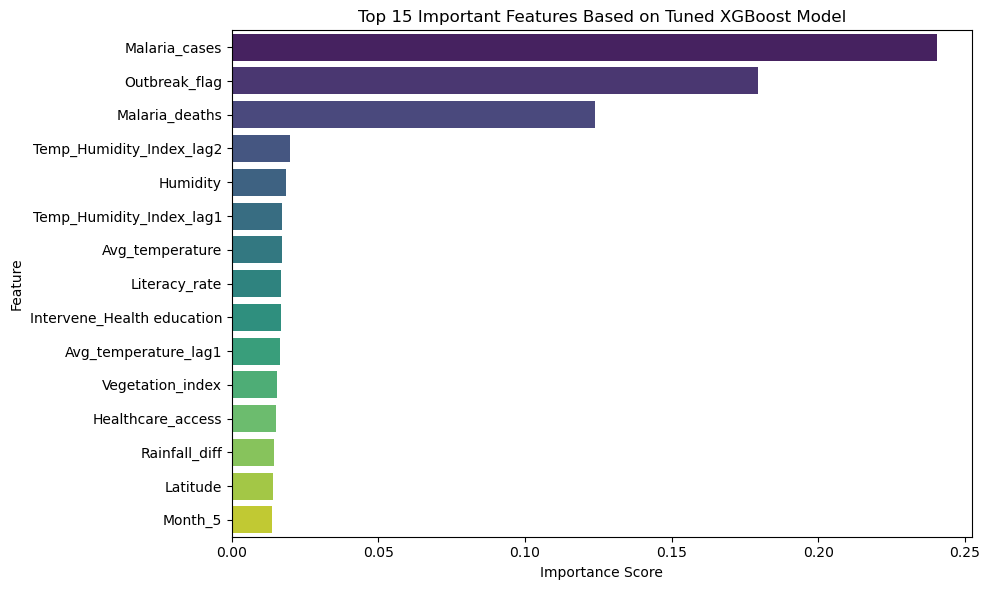

In [12]:
# Get feature importances using built-in estimator interface
importances = tuned_xgb.feature_importances_  # array of importances
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(len(importances))]

# Create a DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features Based on Tuned XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

---

The top 15 features were plotted **using gain-based feature importance**.

The resulting chart ranks features by how much they contribute to improving the model’s predictive performance. Features with higher scores are more influential in predicting malaria incidence. 

This can guide public health focus areas (e.g., rainfall, healthcare access, literacy, and so on).

---

#### **Model 6: Stacked Model of 3 Earlier Trained Models**

In [13]:
from sklearn.ensemble import StackingRegressor

# Define base learners
base_learners = [
    ('elasticnet', Enet_model),
    ('rf', rf_model),
    ('xgb', tuned_xgb)
]

# Meta learner
meta_learner = Ridge(random_state=42)

# Stacking Regressor
stacked_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

# Fit model
stacked_model.fit(X_train, y_train)

# Evaluate
y_pred_stack = stacked_model.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacked Model RMSE: {rmse_stack:.4f}")
print(f"Stacked Model R2: {r2_stack:.4f}")


Stacked Model RMSE: 0.5786
Stacked Model R2: 0.6855


---

The stacked model, combining ElasticNet, Random Forest, and the tuned XGBoost with Ridge as a meta-learner, outperformed all individual models. It combines the strengths of the linear and non-linear models to achieve a good balance between accuracy and robustness, and between bias and variance.

**This confirms that model ensembling enhances generalization in complex datasets.**

---

#### **Finding the Important Features Based on the Stacked Model**

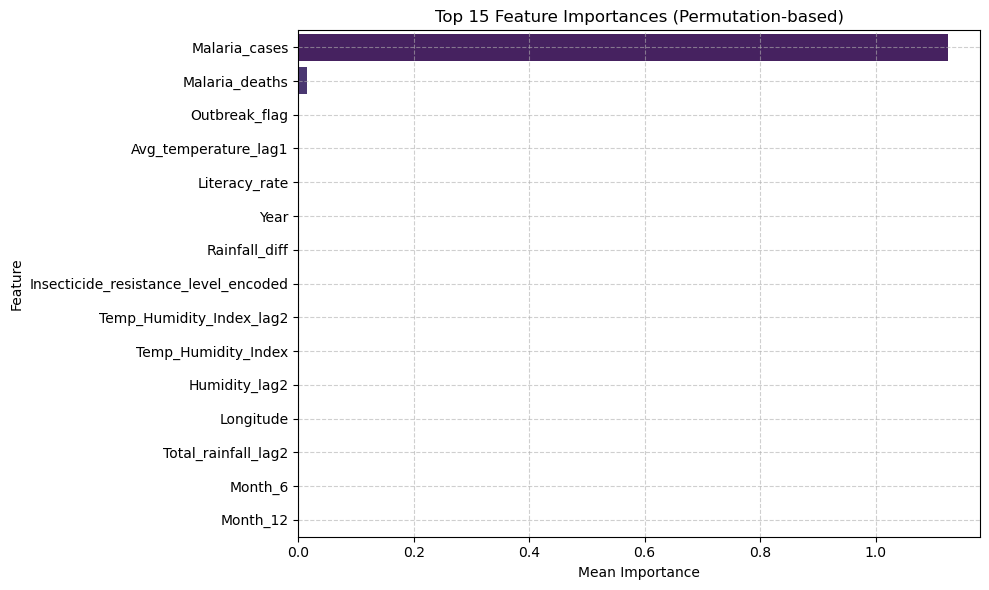

In [14]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(
    stacked_model, X_test, y_test, n_repeats=10,
    random_state=42, n_jobs=-1
)

# Create DataFrame for easy handling
feature_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort and select Top 15
top_features = feature_importances.sort_values(by='importance_mean', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance_mean', y='feature', data=top_features, palette='viridis', orient='h')
plt.title('Top 15 Feature Importances (Permutation-based)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---

Since the StackingRegressor is a meta-model, it does not expose a ".feature_importances_ attribute" directly because it's an ensemble of models.

So, to get the important features, I used **Permutation Importance** (A model-agnostic approach using sklearn.inspection.permutation_importance), which works for any model (including stacking). It is also more general and interpretable for my stacking model.

**Permutation importance measures how prediction error increases when a feature’s values are randomly shuffled.** 
Higher values imply greater influence.

The resulting chart shows the top 15 features most critical to the model’s predictions. Unlike gain or coefficient plots, this directly measures how much performance drops when each feature is shuffled, offering a model-agnostic view of feature importance.

---

#### **Train Final Stacked Model on the Full Dataset**

In [15]:
# Final Training on Full Dataset for forecasting preparation

# Define the full dataset (same feature selection as before)
X_full = df.drop(columns=['Malaria_incidence', 'Malaria_incidence_log', 'Country', 'Date'])
y_full = df['Malaria_incidence_log']

# Define base learners (reusing the tuned and earlier initialized models)
final_base_learners = [
    ('elasticnet', Enet_model),  
    ('rf', rf_model),            
    ('xgb', tuned_xgb)          
]

# Meta learner
final_meta_learner = Ridge(random_state=42)

# Final Stacking Regressor
final_stacked_model = StackingRegressor(
    estimators=final_base_learners,
    final_estimator=final_meta_learner,
    cv=5,
    n_jobs=-1
)

# Train the stacked model on the entire dataset
final_stacked_model.fit(X_full, y_full)

StackingRegressor(cv=5,
                  estimators=[('elasticnet', ElasticNet(random_state=42)),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=N...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                  final_estimator=Ridge(random_state=42), n_jobs=-1)

In [19]:
# Evaluate
y_pred_fstack = final_stacked_model.predict(X_full)
rmse_fstack = np.sqrt(mean_squared_error(y_full, y_pred_fstack))
r2_fstack = r2_score(y_full, y_pred_fstack)

print(f"Final Stacked Model RMSE: {rmse_fstack:.4f}")
print(f"Final Stacked Model R2: {r2_fstack:.4f}")

Final Stacked Model RMSE: 0.4554
Final Stacked Model R2: 0.8115


In [16]:
# Save stacked model to .pkl
joblib.dump(final_stacked_model, 'Final_stacked_malaria_model.pkl')
print("Final stacked model saved as 'Final_stacked_malaria_model.pkl'")

Final stacked model saved as 'Final_stacked_malaria_model.pkl'


### **Conclusion**

1. Among the six models tested, the **stacked ensemble model** performed best with an R² score of 0.6855 and RMSE of 0.5786 on the log-transformed malaria incidence. This means it **explains approximately 68% of the variance in malaria incidence** in the test data. 
- The Linear model (ElasticNet) offered good interpretability but lower predictive power.
- The tree-based models (Random Forest & XGBoost) outperformed the ElasticNet model due to their ability to capture non-linearity and interactions.
- Hyperparameter tuning improved XGBoost more than Random Forest.
- Stacking provided the most balanced and accurate predictions by combining both linear and non-linear strengths.

2. Across the different importance plots (by coefficients, gain, and permutation), **consistent key predictors emerged** (including rainfall, humidity, temperature, malaria cases, and healthcare access), **aligning with domain knowledge in malaria epidemiology.**

3. **Despite using strong models and tuning, none achieved an R² above 70%** (until the final stack model on the full data), suggesting that some unexplained variance remains in the data.
Several possible reasons explain this ceiling in model performance:
- Other important attributes like human movement, local intervention policies, and vector breeding sites/parasite resistance are not captured in the features as the dataset is a generated one.
- Some socioeconomic dynamics data (like migration and housing quality, not caputured in the generated dataset), are hard to quantify but can also heavily affect malaria incidence.
- Predicting the log of malaria incidence makes the target less variable but also more sensitive to errors, especially where true malaria incidence is very low or zero.

Overall, because of **inherent stochasticity** as malaria transmission is inherently complex and seasonal (influenced by non-linear weather and ecological feedback loops), no model can capture all of it without very fine-grained data.

### **Recommendations**

To implement any of the models above for real-world use; 
- Seek higher-resolution data (e.g., data at sub-national or district/state level) to better capture local variability.
- Incorporate intervention data, mosquito resistance data, and climatic anomalies data.
- Explore geospatial modeling with spatial autocorrelation or mixed-effects models to account for country differences.
- Experiment with classification framing (e.g., high vs low incidence) if continuous prediction remains noisy.

Lastly, don't be afraid to **communicate uncertainty.** Malaria incidence risk is probabilistic, not deterministic.